# Variational Inference

## 0. Initialize

In [1]:
#mathematics
using Flux
using LinearAlgebra
using ForwardDiff
using SpecialFunctions

#statistics
using Random
using Statistics
using Distributions

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. Mean Field Variational Inference

In [2]:
# Gibbs sampler
function my_Gibbs_sampler(data, model_params, n_samps)
    @unpack X, n_data = data
    @unpack β = model_params
    n_burnin = div(n_samps, 10)
    sum_data = sum(X)
    
    #initialize
    μsamps = zeros(n_samps); λsamps = ones(n_samps)
    
    @showprogress for s in 2:n_samps
        μsamps[s] = rand(Normal(λsamps[s-1]*sum_data/(λsamps[s-1]*n_data+1),1/sqrt(λsamps[s-1]*n_data+1)))
        λsamps[s] = rand(Gamma(n_data/2+1, 1/(β + 0.5*sum((X .- μsamps[s-1]).^2))))
    end
    true_post_samps = (μsamps=μsamps[n_burnin:end], λsamps=λsamps[n_burnin:end])
    return true_post_samps
end

#ELBO
function ELBO(X, n_data, sum_data, sum_sq_data, m_hat, l_hat, α_hat, β_hat)
    (
        -0.5*log(l_hat) + 0.5 - α_hat*log(β_hat) + loggamma(α_hat) - 
        (α_hat-1)*(digamma(α_hat) - log(β_hat)) + α_hat + 
        0.5*n_data*(digamma(α_hat)-log(β_hat)-log(2*π)) - 
        0.5*α_hat*(n_data/l_hat+sum_sq_data-2*m_hat*sum_sq_data+n_data*m_hat^2)/β_hat-
        0.5*(m_hat^2+1/l_hat)+log(β)-α_hat*β/β_hat
    )
end

#mean-field variational inference
function my_mean_field_VI(data, model_params, n_train)
    @unpack X, n_data = data
    @unpack β = model_params
    
    #initialize
    m_hat, l_hat, α_hat, β_hat= 0, 1, 1+0.5*n_data, 1
    sum_data = sum(X); sum_sq_data = sum(@. X^2)
    history = zeros(n_train)
    
    @showprogress for k in 1:n_train
        history[k] = ELBO(X, n_data, sum_data, sum_sq_data, m_hat, l_hat, α_hat, β_hat)
        
        #update
        l_hat = 1 + n_data*α_hat/β_hat
        m_hat = sum_data*α_hat/β_hat/l_hat
        β_hat = β + 0.5*sum_sq_data - m_hat*sum_data + 0.5*n_data*m_hat^2 + 0.5*n_data/l_hat
    end
    trained_model = (μ_var_post = Normal(m_hat, 1/sqrt(l_hat)), λ_var_post = Gamma(α_hat,1/β_hat))
    return trained_model
end

#true distribution
function true_pdf(x, true_dist)
    pdf(true_dist,x)
end

#variational posterior
function var_post(μ, λ, μ_var_post, λ_var_post)
    exp(logpdf(μ_var_post, μ) + logpdf(λ_var_post, λ))
end

#model
function pmodel(x,μ,λ)
    pdf(Normal(μ,1/sqrt(λ)), x)
end

#predictive
function ppred(x, post_samps)
    @unpack μsamps,λsamps = post_samps
    n_samps = length(μsamps)
    preds = zeros(n_samps)
    for s in 1:n_samps
        preds[s] = pmodel(x,μsamps[s],λsamps[s])
    end
    return mean(preds)
end

#visualize results
function visualize_results(true_dist, true_post_samps, trained_model)
    #variational and true posterior
    @unpack μsamps, λsamps = true_post_samps
    @unpack μ_var_post, λ_var_post = trained_model
    
    #variational posterior sample
    n_samps = 5000
    var_post_samps = (μsamps=rand(μ_var_post, n_samps), λsamps=rand(λ_var_post, n_samps))
    
    #visualize
    μs = -2:0.1:3; λs = 0.01:0.01:0.8; xs = -5:0.1:5
    p_post = plot(μs, λs, (μ,λ)->var_post(μ,λ,μ_var_post,λ_var_post), st=:heatmap, c =:heat, 
        xlabel="μ",ylabel="λ", title="approximated and true posterior", xlim=[-2,3], ylim=[0.01,0.6])
    plot!(μsamps, λsamps, st=:scatter, alpha=0.1, label="GS", markerstrokewidth=0.2, color=:green)
    p_pred = plot(xs, x->true_pdf(x, true_dist), color=:red, lw=3, label="true", title="predictive")
    plot!(xs, x->ppred(x,true_post_samps), color=:green, ls=:dash, lw=3, label="GS")
    plot!(xs, x->ppred(x,var_post_samps), color=:orange, ls=:dashdot, lw=3, label="VI")
    return plot(p_post, p_pred, size=(1000,400), legend=:topleft)
end

visualize_results (generic function with 1 method)

  0.920284 seconds (2.78 M allocations: 152.982 MiB, 2.62% gc time, 99.89% compilation time)
  0.269005 seconds (760.10 k allocations: 44.523 MiB, 10.62% gc time, 99.95% compilation time)


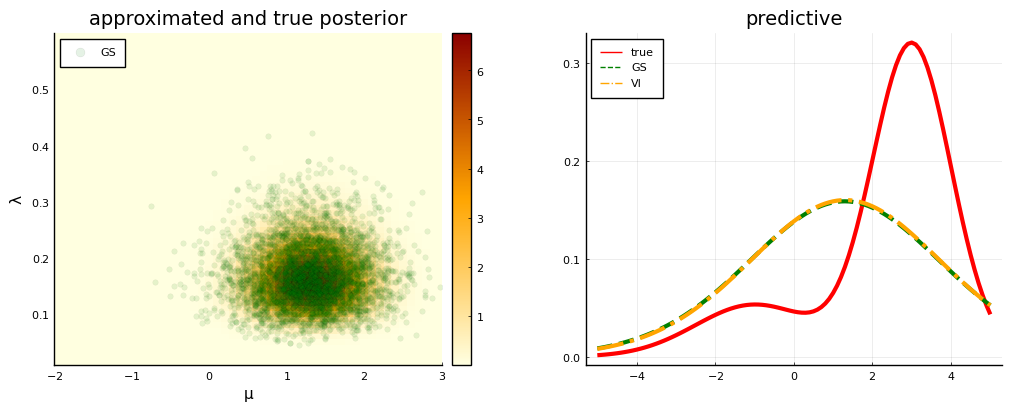

In [3]:
#create data
Random.seed!(42)
μ₁ = -1; μ₂ = 3; σ₁ = 1.5; σ₂ = 1.0; n_data = 20
true_dist = MixtureModel([Normal(μ₁,σ₁), Normal(μ₂,σ₂)], [0.2,0.8])
data = (X=rand(true_dist, n_data), n_data=n_data)

#build model
β = 1e1
model_params = (β=β,)

#Gibbs sampler 
n_samps = 5000
@time true_post_samps = my_Gibbs_sampler(data, model_params, n_samps)

#mean field variational inference
n_train = 100
@time trained_model = my_mean_field_VI(data, model_params, n_train)

#visualize results
fig1 = visualize_results(true_dist, true_post_samps, trained_model)
savefig(fig1, "figs-VI/fig1.png")

## 2. Gradient Based Variational Inference

In [4]:
#log posterior
function logppost(wvec, data)
    @unpack X, Y = data
    sum(@. logpdf(Bernoulli(sigmoid(wvec[1] + wvec[2]*X)), Y)) + logpdf(MvNormal(zeros(2), 1), wvec)
end

#one step of Störmer-Verlet method
function myStörmerVerlet(qvec, pvec, h, f)
    p_mid = pvec + h * f(qvec)/2;
    q_new = qvec + h * p_mid;
    p_new = p_mid + h * f(q_new)/2;
    return q_new, p_new
end

#update the position
function update(T, h, f, qvec, pvec)
    qvec_new = qvec
    pvec_new = pvec
    for t in 1:T
        qvec_new, pvec_new = myStörmerVerlet(qvec_new, pvec_new, h, f)
    end
    return qvec_new, pvec_new
end

#MH acceptance and rejection
function accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
    ΔH = H(xvec, pvec)-H(xvec_old, pvec_old)
    α = min(1.0, exp(-ΔH))
    u = rand()
    if u≤α
        return xvec, pvec
    else
        return xvec_old, pvec_old
    end
end

#Hamiltonian Monte Carlo
function my_HMC(data, model_params, train_params)
    @unpack dw = model_params
    @unpack n_samps, T, h = train_params
    
    #initialization
    n_burnin = div(n_samps,10)
    wsamps = zeros(dw, n_samps)
    wvec = zeros(dw)
    pvec = zeros(dw)
    
    #Hamiltonian and potential
    U(wvec) = -logppost(wvec, data)
    ∇Uneg(wvec) = -ForwardDiff.gradient(U, wvec)
    H(wvec, pvec) = U(wvec) + norm(pvec)^2/2
    
    #sample
    wvec_old = wsamps[:,1]
    pvec_old = randn(dw)
    @showprogress for s in 2:n_samps
        pvec = randn(dw)
        wvec, pvec = update(T, h, ∇Uneg, wvec, pvec)
        wvec, pvec = accept_or_reject(wvec, wvec_old, pvec, pvec_old, H)
        wsamps[:,s] = wvec
        wvec_old = wvec
        pvec_old = pvec
    end
    true_post_samps = (wsamps=wsamps[:,n_burnin:end], )
    return true_post_samps
end 

#reparameterize
function reparameterize(w_mean, w_logstd)
     w_mean + exp.(w_logstd) .* randn(2)
end

#log pdf of model
function logpmodel(y,x,wvec)
    (@. logpdf(Bernoulli(sigmoid(wvec[1]+wvec[2]*x)), y))
end

#ELBO
function ELBO(X,Y,ηvec,n_data)
    sum(logpmodel(Y,X,reparameterize(ηvec[1:2], ηvec[3:4]))) + sum(ηvec[3:4])+1-0.5*norm(ηvec)^2
end

#set trainable parameters and loss function of the model
function build_model(X,Y,n_data)
    ηvec = zeros(4)
    ps = Flux.params(ηvec)
    loss_func = (X,Y) -> -ELBO(X,Y,ηvec,n_data)
    return ηvec, loss_func, ps
end

function my_VI(data, n_train)
    @unpack X,Y,n_data = data
    opt = ADAM(1e-2)
    history = zeros(n_train)
    ηvec, loss_func, ps = build_model(X,Y,n_data)
    
    @showprogress for k in 1:n_train
        Flux.train!(loss_func, ps, [(X,Y)], opt)
        history[k] = loss_func(X,Y)
    end
    trained_model = (w_var_post = MvNormal(ηvec[1:2], exp.(ηvec[3:4])), )
    return trained_model, history
end

#true success probability 
function true_prob(x, true_wvec)
    @unpack w₁, w₂ = true_wvec
    sigmoid(w₁+ w₂*x)
end

#variational posterior 
function var_post(wvec, w_var_post)
    exp(logpdf(w_var_post, wvec))
end

#success probability weighted by posterior
function ppred(x, post_samps)
    @unpack wsamps = post_samps
    n_samps = size(wsamps, 2)
    preds = zeros(n_samps)
    for s in 1:n_samps
        preds[s] = exp(logpmodel(1,x,wsamps[:,s]))
    end
    return mean(preds)
end

#visualize
function visualize_results(true_wvec, true_post_samps, trained_model)
    #variational and true posterior
    @unpack wsamps = true_post_samps
    @unpack w_var_post = trained_model
    
    #variational posterior sample
    n_samps = 5000
    var_post_samps = (wsamps=rand(w_var_post, n_samps), )
    
    #visualize
    w₁s = -4:0.1:4; w₂s = -2:0.1:6; xs = -10:0.2:10
    p_post = plot(w₁s, w₂s, (w₁,w₂)->var_post([w₁,w₂], w_var_post), st=:heatmap, c =:heat, 
        xlabel="w₁", ylabel="w₂", title="approximated and true posterior", xlim=[-4,4], ylim=[-2,6])
    plot!(wsamps[1,:], wsamps[2,:], st=:scatter, alpha=0.1, label="HMC", markerstrokewidth=0.2, color=:green)
    p_pred = plot(xs, x->true_prob(x, true_wvec), label="true", color="red", title="p(y=1)")
    plot!(xs, x->ppred(x,true_post_samps), color=:green, ls=:dash, lw=3, label="HMC")
    plot!(xs, x->ppred(x,var_post_samps), color=:orange, ls=:dashdot, lw=3, label="VI")
    return plot(p_post, p_pred, size=(1000,400), legend=:topleft)
end

visualize_results (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  5.559473 seconds (30.49 M allocations: 2.176 GiB, 10.04% gc time, 65.03% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


 25.886338 seconds (56.59 M allocations: 3.260 GiB, 4.45% gc time, 61.85% compilation time)


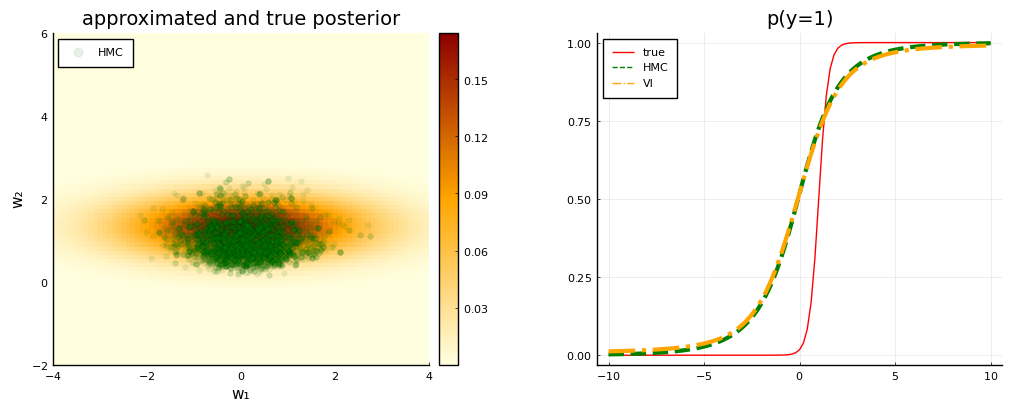

In [5]:
#create data
Random.seed!(42)
true_wvec = (w₁=-4, w₂=4)
n_data = 10
X = sort(rand(-10:10,n_data))
Y = @. rand(Bernoulli(sigmoid(true_wvec.w₁+true_wvec.w₂*X)))
data = (X=X, Y=Y, n_data=n_data)

#HMC parameters
train_params = (n_samps=5000, T=100, h=0.1)
model_params = (dw=2, )
@time true_post_samps = my_HMC(data, model_params, train_params)

#variational inference
n_train = 1000
@time trained_model, history = my_VI(data, n_train)

fig2 = visualize_results(true_wvec, true_post_samps, trained_model)
savefig(fig2, "figs-VI/fig2.png")